
# Modeling the Behavior of an RLC Circuit with an AC input


Abstract

This essay models and analyzes the output voltage of an RLC circuit with an AC input voltage. To answer this question, we built a stock-and-flow model, in which the voltage output is treated as a state variable. By comparing with the result from the theoretical calculates, our model is verified. Our results are compatible with both the theoretical calculations from a transfer function and the experimental result from the ISIM Lab. The result reveals the correlation between the offset and attenuation and the frequency of voltage input. This project reveals the interconnection between ISIM and ModSim by approaching the behavior of the RLC circuit from both an empirical perspective and a theoretical modulation. 

I. Importing Python libraries that are applicable in the following essay. 

In this essay, a number of libraries are used besides ModSim, including control, numpy, scipy and matplotlib.pyplot. The existing functions in these imported libraries make the code clearer and more succint. 

In [6]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import control as cntrl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

II. Defining system

In this section, the system (the value of the inductor, capacitor and resistor) are being defined. By running make_system, a set of system value is updated. 

<img src="RLC.png" alt="Drawing" style="width: 200px;"/>

In [7]:
def make_params(L, C, R):
    return Params(L = L, C = C, R = R)

'''def make_system(params): 
    unpack(params)
    init=State(V=0, dV=0)
    
    sim_timestep = 0.01
    sys = System(
        init=init,
        R=R,
        L=L,
        C=C,
        Vmag=Vmag,
        dV0=dV0,
        freqIn=freq,
        sim_timestep=0.1,
        t_end = 2.5,
    )

    return sys
params = make_params(4.7e-5, 4.7e-5, 1e3)
system = make_system(params)
'''
params = make_params(4.7e-5, 4.7e-5, 1e3)

,values
L,0.000047
C,0.000047
R,1000.000000


In [20]:
def make_system(params): 
    unpack(params)
    init=State(V=0, dV=0)
    
    sim_timestep = 0.01
    t_end = 2.5
    f = 1000
    omega = 2 * np.pi * f
  

    return System(
        init=init,
        R=R,
        L=L,
        C=C,
        #Vmag=Vmag,
        #dV0=dV0,
        #freqIn=freq,
        sim_timestep=sim_timestep,
        t_end=t_end,
    )

system = make_system(params)

,values
init,V 0 dV 0 dtype: int64
R,1000
L,4.7e-05
C,4.7e-05
sim_timestep,0.01
t_end,2.5


III. Defining the transfer function of the circuit. 

The function used for modeling for this circuit is generated by the transfer function of an RLC circuit: 
$\frac{V_o}{V_i}=\frac{(ω^2)RC}{\sqrt{(1-ω^2LC)^2+(ωRC)^2}}$.

By seperating the coefficients of ω, the equation is more explicitly shown. The "top" and "bottom" in the following section presents the numerator and denominators of the transfer function. 


In [9]:
top = np.asarray([1])
bottom = np.asarray([system.L*system.C, system.R*system.C, 1])

array([2.209e-09, 4.700e-02, 1.000e+00])

In [10]:
sys_tf = cntrl.tf(top, bottom)
sys_ss = cntrl.tf2ss(sys_tf)
sys_ss_d = cntrl.c2d(sys_ss, system.sim_timestep)
np.zeros((sys_ss_d.B.shape[0], 1))

array([[0.],
       [0.]])

IV. Defining step functions

A step function is used to simulate the step response of the circuit. "Matmul" (matrix multiplication) is used to present the output of this function. 

In [13]:
def step(sys, mag=1.0, time=5):
    state = np.zeros((sys.A.shape[0], 1))
    dt = sys.dt
    t = []
    y = []
    for i in range(int(time/dt)):
        state = np.matmul(sys.A, state) + sys.B*mag
        output = np.matmul(sys.C, state)
        t.append(i*dt)
        y.append(float(output))
    return t,y

In [14]:
t, y = step(sys_ss_d, mag=1.0, time=1)

In [15]:
def lsim(sys, vec):
    state = np.zeros((sys.A.shape[0], 1))
    dt = sys.dt
    t = []
    y = []
    for i in range(len(vec)):
        state = np.matmul(sys.A, state) + sys.B*vec[i]
        output = np.matmul(sys.C, state)
        t.append(i*dt)
        y.append(float(output))
    return t,y
sin_x = np.linspace(0, 8*np.pi, 100)
sin_y = np.sin(sin_x)
t, y = lsim(sys_ss_d, sin_y)
sin_x /= 8*np.pi

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

V. Graphing the results

In the following section, a graph of an ideal RLC filter step response is presented. 

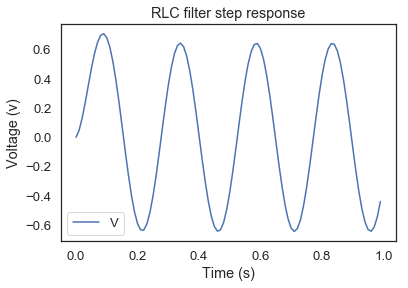

In [16]:
plt.plot(t, y)
plt.legend("V")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (v)")
plt.title("RLC filter step response")
plt.show()



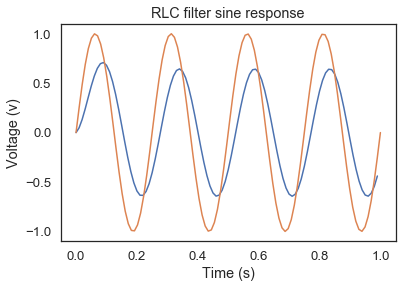

In [13]:
plt.plot(t, y, sin_x, sin_y)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (v)")
plt.title("RLC filter sine response")
plt.show()

VI. Simulation with ODE solver

In the following section, an ODE solver is used to optimize the best dt for the given situation. 

In [17]:
def slope_func(state, t, system): 
    V, dV = state
    unpack(system)

    #print(Vmag*sin(freq*t))
    d2V = L/R * C * Vmag * sin(freq*t) - 1/R * L * C * V - 1/L * dV
    #d2V = ((L/R*C) * (Vmag*sin((freq)*t)) - ((1/R*L*C)*V) - ((1/L)*dV))
    #print(L/R * C * Vmag * sin(freq*t) - 1/R * L * C * _V - 1/L * dV)
    # LI'' + RI' + 1/C I = V'

    return dV, d2V


In [18]:
results, detail = run_ode_solver(system, slope_func,
t_eval=data.index)

NameError: name 'data' is not defined

In [ ]:
def plot_results_V(results):
    
    plot(results.V, 'g-')

    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)')
    
plot_results_V(results)

         

In [ ]:
fs = [1, 10, 100, 1000, 10000, 100000]

def sweep_freq():
    ratios = TimeSeries()
    offsets = TimeSeries()
    
    for i, f in enumerate(fs):
        system = make_system(Params(params, f=f))
        series = compute_vin(results, system)
        V = estimate_A(series)
        A_in = estimate_A(V_in)
        A_out = estimate_A(V_out)

        ratios = A_out / A_in
        offsets = compute_offset(corr)


    return ratios, offsets


VII. Estimating the output ratio

In the following section the amplitude of the input and output signals are analyzed. Within the range of cutoff frequency, we expect them to be about the same. Outside the range, we expect the amplitude of the output signal to be much smaller. The example uses $f=1000$ as the frequency. After testing, we sweep the frequency again. 

In [ ]:
system = make_system(Params(params, f=1000))
results, details = run_ode_solver(system, slope_func, t_eval=data.index)
V_out = results.V
plot_results(results)


In [ ]:
def compute_vin(results, system):
   
    unpack(system)
    V_in = A * np.cos(omega * results.index)
    return TimeSeries(V_in, results.index, name='V_in')

def estimate_A(series):
    return (series.max() - series.min()) / 2


def compute_offset(corr):
    peak_time = corr.idxmax()
    period = 1 / system.f
    frac, whole = np.modf(peak_time / period)
    return frac

def estimate_offset(V1, V2, system):

    corr = np.correlate(V1, V2, mode='same')
    corr = TimeSeries(corr, V1.index)
    peak = corr.idxmax()
    period = 1 / system.f
    frac, whole = np.modf(peak / period)
    return -frac * 360

In [ ]:
corr = np.correlate(V_out, V_in, mode='same')
corr = TimeSeries(corr, V_in.index)

In [ ]:
def sweep_frequency(fs, params):
    ratios = SweepSeries()
    offsets = SweepSeries()

    for i, f in enumerate(fs):
        system = make_system(Params(params, f=f))
        results, details = run_ode_solver(system, slope_func, t_eval=system.ts)
        V_out = results.V_out
        V_in = compute_vin(results, system)
        ratios[f] = estimate_ratio(V_out, V_in)
        offsets[f] = estimate_offset(V_out, V_in, system)
    return ratios, offsets

fs = 10 ** linspace(0, 4, 9)
ratios, offsets = sweep_frequency(fs, params)

In [ ]:
def plot_ratios(ratios, system):
    """Plot output ratios.
    """
    plt.axvline(system.cutoff, color='gray', alpha=0.4)
    plot(ratios, color='C2', label='output ratio')
    decorate(xlabel='Frequency (Hz)',
             ylabel='$V_{out} / V_{in}$',
             xscale='log', yscale='log')

In [ ]:
plot_ratios(ratios, system)

In [ ]:
def plot_offsets(offsets, system):
    """Plot phase offsets.
    """
    plt.axvline(system.cutoff, color='gray', alpha=0.4)
    plot(offsets, color='C9')
    decorate(xlabel='Frequency (Hz)',
             ylabel='Phase offset (degree)',
             xscale='log')

In [ ]:
plot_offsets(offsets, system)